# Data Challenge 

### Challenge Large Scale Machine Learning :  Fusion of algorithms for face recognition


Info on the challenge available on the link below.
https://github.com/yamhiroto/Data-Challenge-MS-BGD-2020

In [9]:
%matplotlib inline
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pandas as pd

import seaborn as sns
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import Experiment, RunInfo
import mlflow.sklearn
import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)
  
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

#import pickle
from datetime import datetime

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

    

In [15]:
#to start tracking my different models on MLFlow
mlflow.set_tracking_uri("mlflow_record")

In [5]:
def get_or_create_experiment(experiment_name) -> Experiment:
    """
    Creates an mlflow experiment
    :param experiment_name: str. The name of the experiment to be set in MLFlow
    :return: the experiment created if it doesn't exist, experiment if it is already created.
    """
    try:
        client = MlflowClient()
        #experiment: Experiment = client.get_experiment_by_name(name=experiment_name)
        experiment = client.get_experiment_by_name(name=experiment_name)
        if experiment and experiment.lifecycle_stage != 'deleted':
            return experiment
        else:
            experiment_id = client.create_experiment(name=experiment_name)
            return client.get_experiment(experiment_id=experiment_id)
    except Exception as e:
        logger.error('Unable to get or create experiment {experiment_name}:' + str(e))

In [6]:
experiment_name = 'Data Challenge Telecom Paris'
experiment= get_or_create_experiment(experiment_name)

In [2]:
def eval_metrics1(ypredicted,yvalid):#
    '''
    Calculate the performance metric
    '''
    yvalid_scoreordered = yvalid[np.argsort(ypredicted)]
    #print(yvalid_scoreordered)
    N = np.sum(yvalid == 0)
    P = np.sum(yvalid == 1)
    FP = 0
    TP = 0
    
    for i in range(yvalid_scoreordered.shape[0] -1, -1, -1):
        if (yvalid_scoreordered[i] == 1):
            TP = TP + 1
        else:
            FP = FP + 1
        if (FP / N > 10**-4):
            FP = FP - 1
           
            break
      
    FPR = FP/N
    TPR = TP/P
    return N,P,FP,TP,FPR,TPR
         

## Load and Investigate the Data

In [3]:
xtrain = pd.read_csv('xtrain_challenge.csv') 

In [4]:
ytrain = pd.read_csv('ytrain_challenge.csv') 

In [5]:
xtest = pd.read_csv('xtest_challenge.csv') 

In [6]:
#split training set of features as trainingand validation set
train, valid, ytraining, yvalidation = train_test_split(xtrain,ytrain ,test_size = 0.1 ,random_state=0)### File xtrain_challenge.csv contains one observation per row which contains following entries based on a pair of images:

# columns 1-13 - 13 qualities on first image;
# columns 14-26 - 13 qualities on second image;
# columns 27-37 - 11 matching scores between the two images.

In [ ]:
train.head()

## Data Exploration

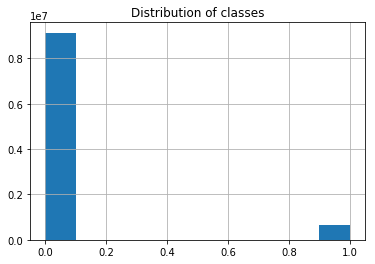

In [26]:
# Plotting distribution of classes
ytrain.hist()
plt.title("Distribution of classes")
plt.show()

**Notes** : Classes are really imbalanced, { 0 : non match / 1 : match between pairs}. This will need to be taken into account when fitting algorithm

In [33]:
count_1 = ytrain[ytrain['y']==1].shape[0]
count_0 = ytrain[ytrain['y']==0].shape[0]

In [34]:
print("number of pairs without match : " + str(count_0) )  
print("number of pairs with match : " + str(count_1) ) 
print("ratio 0 to 1 : "  + str(count_0/count_1))

number of pairs without match : 9127661
number of pairs with match : 673052
ratio 0 to 1 : 13.561598509476237


**Notes** : Let's explore the distribution. Since the training set is large, we will work on a smaller subset

In [35]:
dftrain = pd.concat([xtrain, ytrain], axis=1)

In [12]:
# Creating a random subset of original dataset in order to fasten data exploration
dftrain_sample = xtrain.sample(n=xtrain.shape[0]//1000)
dftest_sample = xtest.sample(n=xtest.shape[0]//1000)

## Correlation Matrix

In [14]:
corr_train = dftrain_sample.corr()


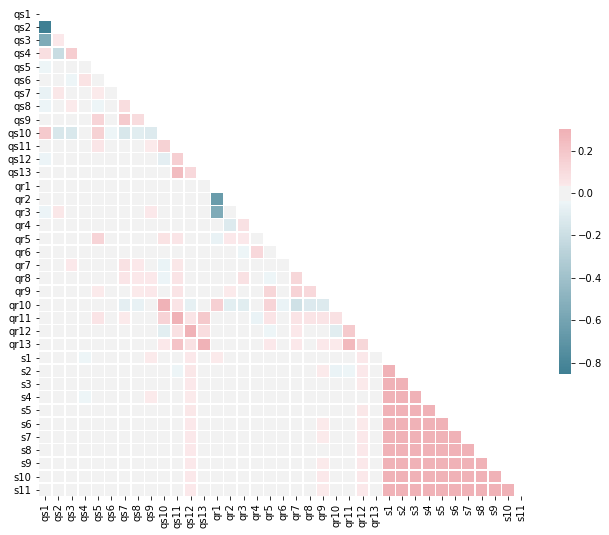

In [18]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Notes** : We can observe a high correlation between the columns S1 to S8 which seems logic since those are the matching score between the both pictures of the image.

### NaN value?

In [20]:
dftrain_sample.isna().sum()
dftest_sample.isna().sum()

qs1     0
qs2     0
qs3     0
qs4     0
qs5     0
qs6     0
qs7     0
qs8     0
qs9     0
qs10    0
qs11    0
qs12    0
qs13    0
qr1     0
qr2     0
qr3     0
qr4     0
qr5     0
qr6     0
qr7     0
qr8     0
qr9     0
qr10    0
qr11    0
qr12    0
qr13    0
s1      0
s2      0
s3      0
s4      0
s5      0
s6      0
s7      0
s8      0
s9      0
s10     0
s11     0
dtype: int64

Notes : there is no Nan value in the datasets.

### Plotting distribution of data

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


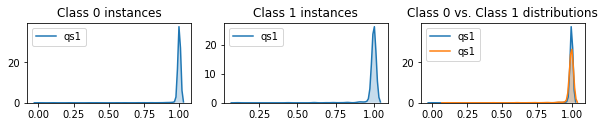

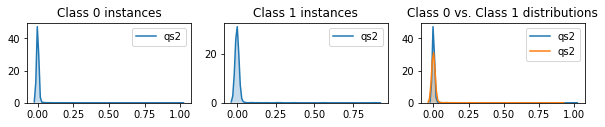

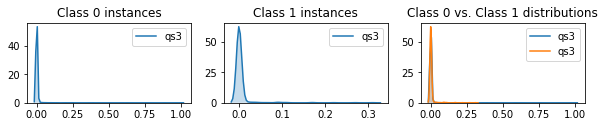

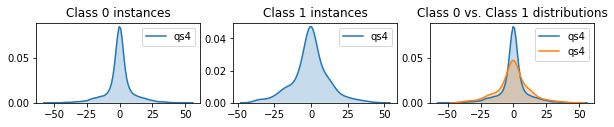

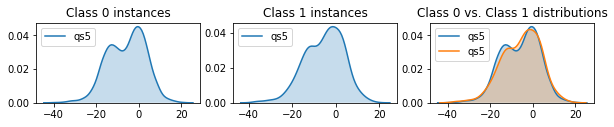

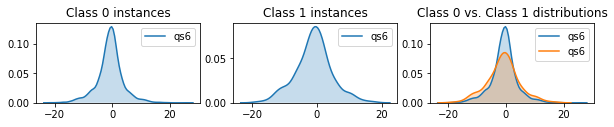

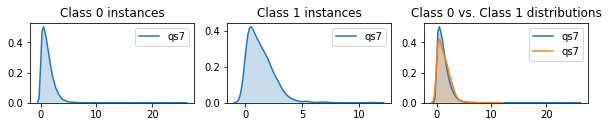

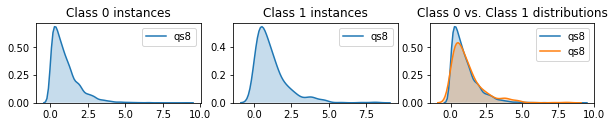

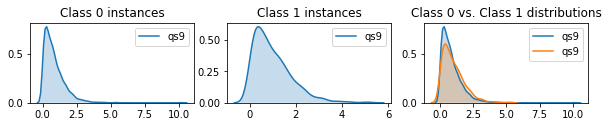

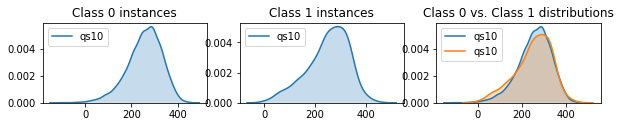

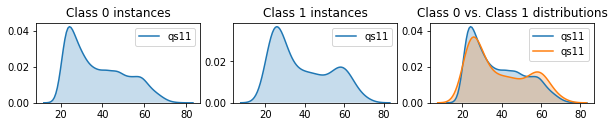

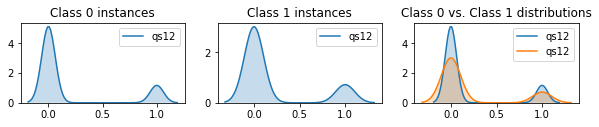

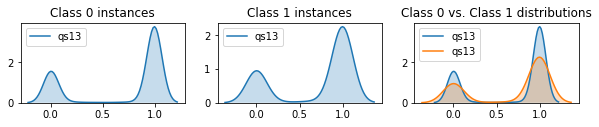

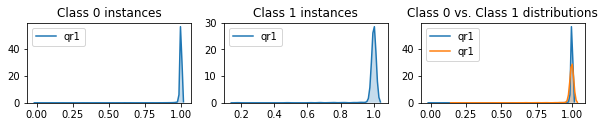

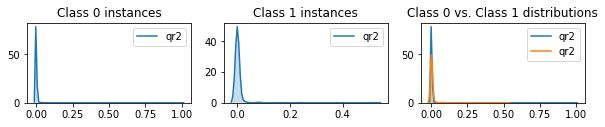

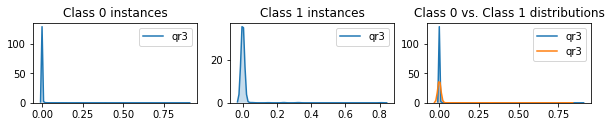

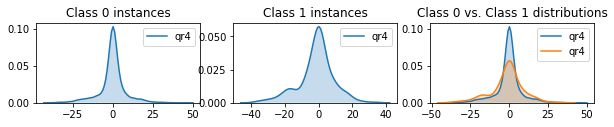

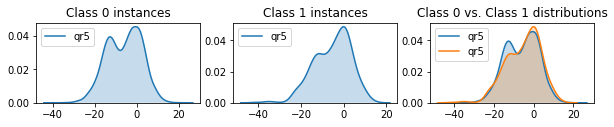

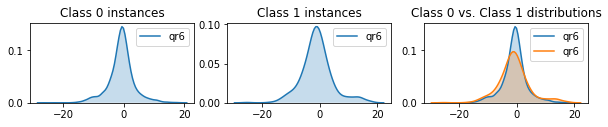

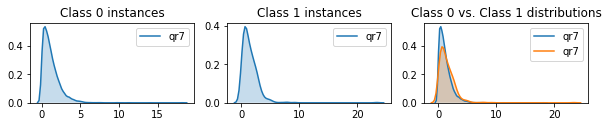

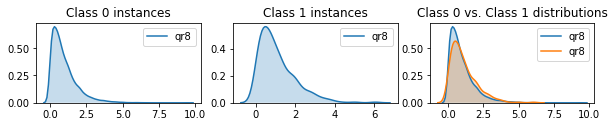

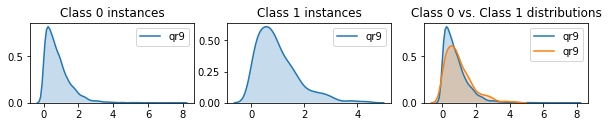

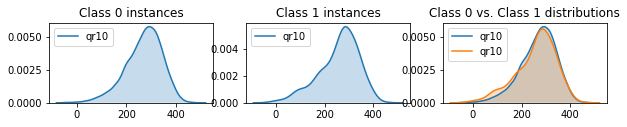

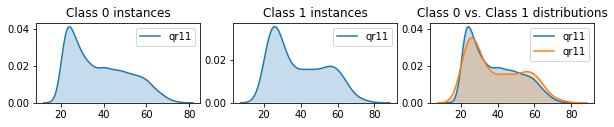

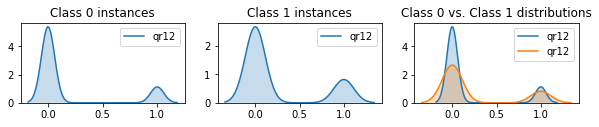

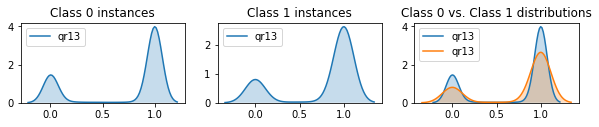

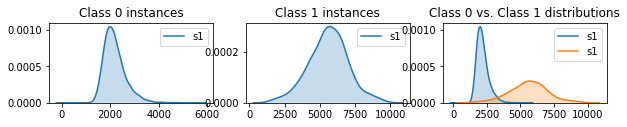

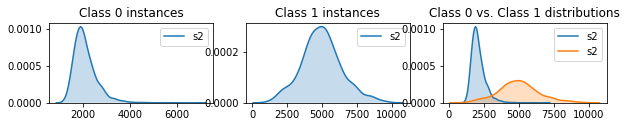

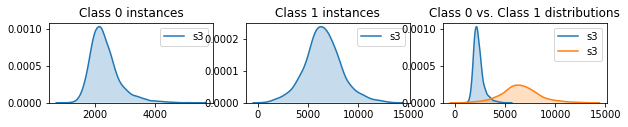

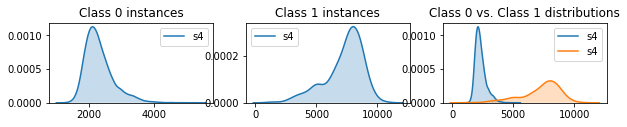

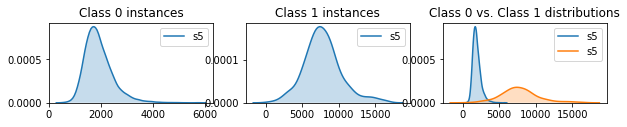

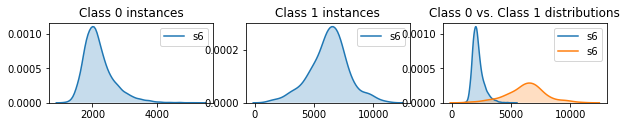

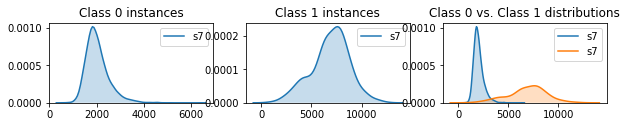

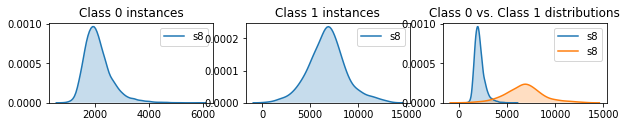

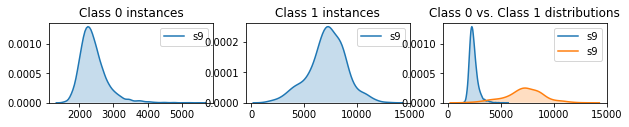

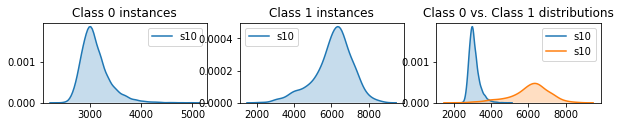

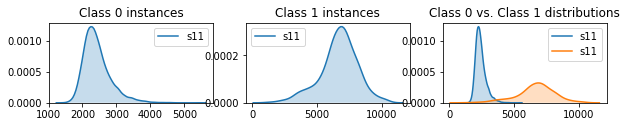

In [39]:

for col in list(dftrain_sample.columns)[:-1]:
    plt.figure(figsize=(10,5))
    plt.subplot(331)
    plt.title("Class 0 instances")
    sns.kdeplot(dftrain_sample[dftrain_sample['y']==0][col], shade=True)

    plt.subplot(332)
    plt.title("Class 1 instances")
    sns.kdeplot(dftrain_sample[dftrain_sample['y']==1][col], shade=True)
    
    plt.subplot(333)
    plt.title("Class 0 vs. Class 1 distributions")
    sns.kdeplot(dftrain_sample[dftrain_sample['y']==0][col], shade=True)
    sns.kdeplot(dftrain_sample[dftrain_sample['y']==1][col], shade=True)

**Notes**: For the last 11 features (representing the matching scores), classes overlap less than for the  26 first features, which makes sense as those are characteristics of images taken independently, whereas features S1 to S11 are indicators of similarity between images. 

It can be guessed that these features will play an important part when training classifiers.

## 1 - Training a simple Classifier
### Logistic Regression

In [13]:
# Train #the classifier on a part of the data set, (49 first rows)
clf_all_column = LogisticRegression()
clf_all_column.fit(train, ytraining.to_numpy().ravel())   #ytraining is an array

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
ypredicted_logreg_all_column = clf_all_column.predict_proba(valid)[:,clf_all_column.classes_ == 1][:,0]
print(ypredicted_logreg_all_column)

[2.34954960e-05 3.35238505e-06 1.63461763e-04 ... 4.39303500e-03
 1.46242084e-05 2.30494243e-05]


In [17]:
N,P,FP,TP,FPR,TPR = eval_metrics1(ypredicted_logreg_all_column,yvalidation.to_numpy().ravel())
print(N,P,FP,TP,FPR,TPR)
print("For the smallest FPR <= 10^-4 (i.e., ", FPR, ") TPR = ", TPR, ".", sep = "")

2282077 168102 228 146779 9.99089864189508e-05 0.8731543943558078
For the smallest FPR <= 10^-4 (i.e., 9.99089864189508e-05) TPR = 0.8731543943558078.
For the smallest FPR <= 10^-4 (i.e., 9.99089864189508e-05) TPR = 0.8731543943558078.


**Note** : the result is not really impressive, we will go on more competitive algorithm.

## 2 - XGBoost

In [7]:
def train_XGB_model(name,n_estimators,max_depth,learning_rate,scale_pos_weight, xtrain,ytraining):
    '''
    - name = name which will be used when saving the model
    - n_estimators,max_depth,learning_rate= hyperparameter from xgboost
    - xtrain = dataframe
    - ytraining = numpy array
    '''
    
    #model with parameter
    clf_xgb = XGBClassifier(n_estimators= n_estimators, max_depth= max_depth, learning_rate = learning_rate, scale_pos_weight = scale_pos_weight, tree_method='gpu_hist')
    
    start=datetime.now()    #to record time to fit it
    
    #fit the model
    clf_xgb.fit(xtrain, ytraining)
    
    time_elapsed = datetime.now()-start
    
    print(time_elapsed)     
    
    # save the model to disk
    filename = name + '.sav'
    pickle.dump(clf_xgb, open(filename, 'wb'))
 

In [8]:
def load_and_predict(name,valid,yvalidation):
    '''
    - name = name to load the model
    - valid = dataframe
    - yvalidation = numpy array
    '''
    
    #load model
    filename = name + '.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    
    #predict_proba
    ypredicted= loaded_model.predict_proba(valid)[:,loaded_model.classes_ == 1][:,0]
    
    #show result
    N,P,FP,TP,FPR,TPR = eval_metrics1(ypredicted,yvalidation)
    print("For the smallest FPR <= 10^-4 (i.e., ", FPR, ") TPR = ", TPR, ".", sep = "")
    
    #log into mlflow
    with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='Data Challenge Telecom Paris'):
    # Log parameter, metrics, and model to MLflow 
        mlflow.log_param("algorithm", name)
        mlflow.log_param("N_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("Learning rate", learning_rate)
        mlflow.log_param("Scale_pos_weight",scale_pos_weight)
        mlflow.log_metric("Number of 0", N)
        mlflow.log_metric("Number of 1", P)
        mlflow.log_metric("FP", FP)  # predicted match while no real match
        mlflow.log_metric("TP", TP)
        mlflow.log_metric("FPR under 10-4", FPR) # FPR under 10**-4
        mlflow.log_metric("TPR_target", TPR)
        mlflow.sklearn.log_model(loaded_model, name)
    
    return(ypredicted)
  

### 1-Stantard Trial

**Notes**: Let's try to run the model once.

In [13]:
name = 'xgboost_standard_3500'
n_estimators = 3500
max_depth=15
learning_rate=0.0013
scale_pos_weight = 1
train_xgb = trainhttps://ocw.mit.edu/resources/res-6-012-introduction-to-probability-spring-2018/index.htm
valid_xgb = valid
ytraining_xgb = ytraining.to_numpy().ravel()
yvalidation_xgb = yvalidation.to_numpy().ravel()

In [14]:
train_XGB_model(name,n_estimators,max_depth,scale_pos_weight,learning_rate,train_xgb,ytraining_xgb)

0:16:29.706865


In [15]:
ypredicted_standard_3500 = load_and_predict(name,valid_xgb,yvalidation_xgb)

For the smallest FPR <= 10^-4 (i.e., 9.968637133940142e-05) TPR = 0.9842580606763975.


In [17]:
#load model
filename = name + '.sav'
loaded_model = pickle.load(open(filename, 'rb'))
    
#predict_proba
ypredicted= loaded_model.predict_proba(xtest)[:,loaded_model.classes_ == 1][:,0]

In [18]:
np.savetxt('YAMAKAWA_Hiroto_standard_3500.csv', ypredicted, fmt = '%1.15f', delimiter=',')

**Notes** : the performance is already better with XGboost. Let's try some preprocessing on the data, such as scaling,oversampling or undersampling

### 2-Scaled trainingset

In [11]:
from sklearn import preprocessing

x_train = train.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)
train_scaled = pd.DataFrame(x_train_scaled)

x_valid = valid.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_valid_scaled = min_max_scaler.fit_transform(x_valid)
valid_scaled = pd.DataFrame(x_valid_scaled)

In [20]:
x_test = xtest.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_test_scaled = min_max_scaler.fit_transform(x_test)
test_scaled = pd.DataFrame(x_test_scaled)

In [18]:
name = 'xgboost_scaled_2500'
n_estimators = 2500
max_depth=9
learning_rate=0.0013
scale_pos_weight=13
train_xgb = train_scaled
valid_xgb = valid_scaled
ytraining_xgb = ytraining.to_numpy().ravel()
yvalidation_xgb = yvalidation.to_numpy().ravel()

In [ ]:
train_XGB_model(name,n_estimators,max_depth,learning_rate,scaled_pos_weight,train_xgb,ytraining_xgb)

In [ ]:
ypredicted_scaled=load_and_predict(name,valid_xgb,yvalidation_xgb)

### 3-Undersampling

In [44]:
# Class count
count_class_0, count_class_1 = ytraining['y'].value_counts()

# concat trainset with labels
train['y']=ytraining

# Divide by class
dftrain_class_0 = train[train['y'] == 0]
dftrain_class_1 = train[train['y'] == 1]

# Resampling class 0 dataframe with number of instances same as class 1 dafatrame
dftrain_class_0_under = dftrain_class_0.sample(count_class_1)
dftrain_undersampled = pd.concat([dftrain_class_0_under, dftrain_class_1], axis=0)

In [32]:
xtrain_under = dftrain_undersampled.drop(columns=['y'])
ytrain_under = dftrain_undersampled['y']

In [33]:
train = train.drop(columns=['y'])

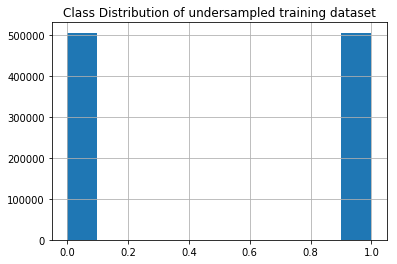

In [34]:
ytrain_under.hist()
plt.title("Class Distribution of undersampled training dataset")
plt.show()

In [36]:
name = 'xgboost_undersampling'
n_estimators = 2500
max_depth=10
learning_rate=0.0013
pos_scale_weight = 1
train_xgb = xtrain_under
valid_xgb = valid
ytraining_xgb = ytrain_under.to_numpy().ravel()
yvalidation_xgb = yvalidation.to_numpy().ravel()

In [38]:
train_XGB_model(name,n_estimators,max_depth,learning_rate,pos_scale_weight,train_xgb,ytraining_xgb)

0:03:33.251896


### 4-Oversampling

In [45]:

# Resampling class 0 dataframe with number of instances same as class 1 dafatrame
dftrain_class_1_over = dftrain_class_1.sample(count_class_0, replace = True)
dftrain_oversampled = pd.concat([dftrain_class_0, dftrain_class_1_over], axis=0)

In [46]:

xtrain_over = dftrain_oversampled.drop(columns=['y'])
ytrain_over = dftrain_oversampled['y']

In [47]:
train = train.drop(columns=['y'])

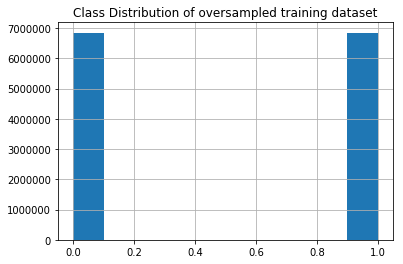

In [48]:

# Checking subsample worked and classes are balanced
ytrain_over.hist()
plt.title("Class Distribution of oversampled training dataset")
plt.show()

In [ ]:
name = 'xgboost_oversampling'
n_estimators = 1500
max_depth=10
learning_rate=0.0013
scale_pos_weight = 1
train_xgb = xtrain_over
valid_xgb = valid
ytraining_xgb = ytrain_over.to_numpy().ravel()
yvalidation_xgb = yvalidation.to_numpy().ravel()

In [ ]:
train_XGB_model(name,n_estimators,max_depth,learning_rate,scale_pos_weight,train_xgb,ytraining_xgb)

In [22]:
load_and_predict(name,valid_xgb,yvalidation_xgb)

For the smallest FPR <= 10^-4 (i.e., 9.991616683019905e-05) TPR = 0.9239596828830542.


NameError: name 'scale_pos_weight' is not defined

**Notes** : It seems that the data preprocessing don't improve the performance that well. Let's try to tune more thoroughly the hyperparameters

## Hyperparameters Tuning

In [37]:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=10,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.9,
                      verbosity =2,
                      objective='binary:logistic', 
                      n_estimators=3500, 
                      reg_alpha = 0.3,
                      max_depth=8, 
                      tree_method='gpu_hist', 
                      gpu_id=0,
                      eval_metric="auc",
                      min_weight_child = 2,
                      gamma=7)

In [38]:
start=datetime.now()    #to record time to fit it
    
#fit the model
model.fit(train, ytraining.to_numpy().ravel(), early_stopping_rounds=5, eval_set=[(valid, yvalidation.to_numpy().ravel())])
    
time_elapsed = datetime.now()-start
print(time_elapsed)     
    
#save the model to disk
filename = 'xgboost_custom2.sav'
pickle.dump(model, open(filename, 'wb'))
 

[0]	validation_0-auc:0.998328
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.998425
[2]	validation_0-auc:0.99843
[3]	validation_0-auc:0.998442
[4]	validation_0-auc:0.998671
[5]	validation_0-auc:0.998679
[6]	validation_0-auc:0.998682
[7]	validation_0-auc:0.998692
[8]	validation_0-auc:0.99877
[9]	validation_0-auc:0.998772
[10]	validation_0-auc:0.998787
[11]	validation_0-auc:0.998834
[12]	validation_0-auc:0.998841
[13]	validation_0-auc:0.99885
[14]	validation_0-auc:0.998863
[15]	validation_0-auc:0.998862
[16]	validation_0-auc:0.998873
[17]	validation_0-auc:0.998873
[18]	validation_0-auc:0.99888
[19]	validation_0-auc:0.99888
[20]	validation_0-auc:0.998891
[21]	validation_0-auc:0.998901
[22]	validation_0-auc:0.998904
[23]	validation_0-auc:0.998913
[24]	validation_0-auc:0.998928
[25]	validation_0-auc:0.998931
[26]	validation_0-auc:0.998935
[27]	validation_0-auc:0.998939
[28]	validation_0-auc:0.998941
[29]	validation_0-auc:0.998949
[30]	validation_0-auc:

#### Feature Importance

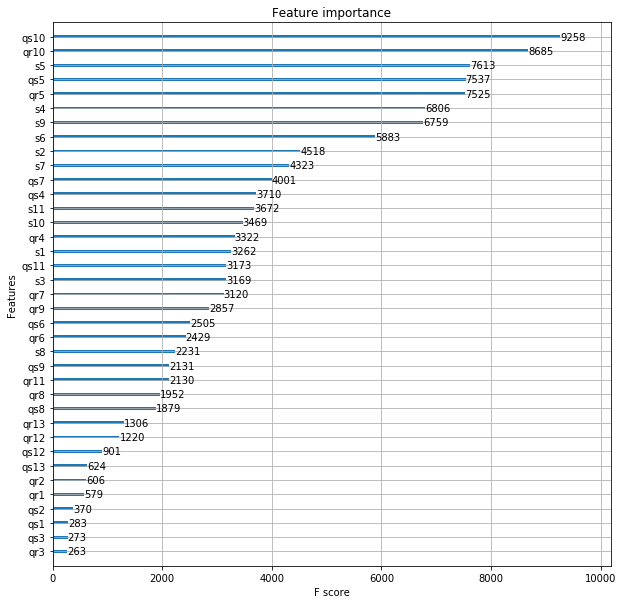

In [44]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(model, ax=ax)

In [14]:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=13,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.9,
                      verbosity =2,
                      objective='binary:logistic', 
                      n_estimators=3500, 
                      reg_alpha = 0.3,
                      max_depth=13, 
                      tree_method='gpu_hist', 
                      gpu_id=0,
                      eval_metric="auc",
                      gamma=5)

In [15]:
start=datetime.now()    #to record time to fit it
    
#fit the model
model.fit(train, ytraining.to_numpy().ravel(), early_stopping_rounds=5, eval_set=[(valid, yvalidation.to_numpy().ravel())])
    
time_elapsed = datetime.now()-start
print(time_elapsed)     
    
#save the model to disk
filename = 'xgboost_custom3.sav'
pickle.dump(model, open(filename, 'wb'))
 

[0]	validation_0-auc:0.998889
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.999029
[2]	validation_0-auc:0.999131
[3]	validation_0-auc:0.999155
[4]	validation_0-auc:0.999163
[5]	validation_0-auc:0.999175
[6]	validation_0-auc:0.999188
[7]	validation_0-auc:0.999271
[8]	validation_0-auc:0.999281
[9]	validation_0-auc:0.999324
[10]	validation_0-auc:0.999336
[11]	validation_0-auc:0.999343
[12]	validation_0-auc:0.999348
[13]	validation_0-auc:0.999348
[14]	validation_0-auc:0.99935
[15]	validation_0-auc:0.999355
[16]	validation_0-auc:0.999359
[17]	validation_0-auc:0.999358
[18]	validation_0-auc:0.999361
[19]	validation_0-auc:0.999371
[20]	validation_0-auc:0.999399
[21]	validation_0-auc:0.999401
[22]	validation_0-auc:0.999403
[23]	validation_0-auc:0.999414
[24]	validation_0-auc:0.999431
[25]	validation_0-auc:0.999433
[26]	validation_0-auc:0.999435
[27]	validation_0-auc:0.999438
[28]	validation_0-auc:0.999439
[29]	validation_0-auc:0.999444
[30]	validation_0-

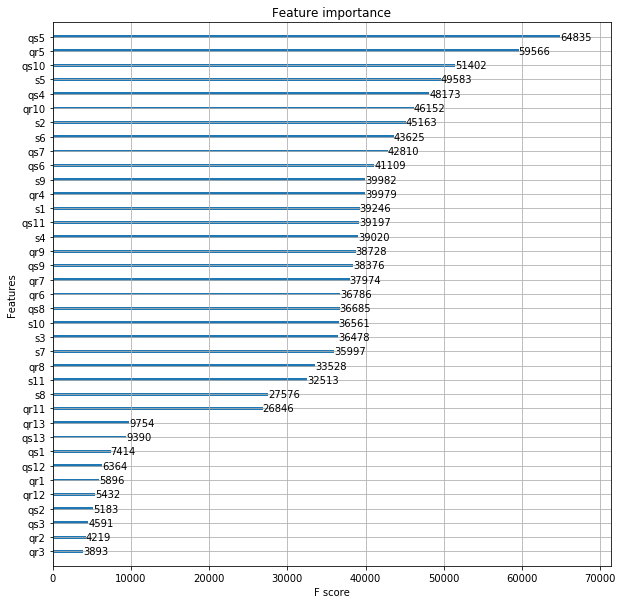

In [45]:
loaded_model = pickle.load(open('xgboost_custom3.sav', 'rb'))

from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(loaded_model, ax=ax)

#ypredicted= loaded_model.predict_proba(xtest)[:,loaded_model.classes_ == 1][:,0]

In [41]:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=10,
                      learning_rate=0.008,  
                      colsample_bytree = 0.7,
                      min_child_weight=3,
                      subsample = 0.6,
                      verbosity =2,
                      objective='binary:logistic', 
                      eval_metric ='logloss',
                      n_estimators=2500, 
                      reg_alpha = 0.3,
                      max_depth=10, 
                      reg_lambda =3,
                      tree_method='gpu_hist', 
                      gpu_id=0,
                      gamma=10,
                    seed =53)



In [42]:
model.fit(train, ytraining.to_numpy().ravel(), early_stopping_rounds=50, eval_set=[(valid, yvalidation.to_numpy().ravel())])

[0]	validation_0-logloss:0.68544
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.67786
[2]	validation_0-logloss:0.67039
[3]	validation_0-logloss:0.66302
[4]	validation_0-logloss:0.65577
[5]	validation_0-logloss:0.64860
[6]	validation_0-logloss:0.64157
[7]	validation_0-logloss:0.63465
[8]	validation_0-logloss:0.62789
[9]	validation_0-logloss:0.62115
[10]	validation_0-logloss:0.61454
[11]	validation_0-logloss:0.60803
[12]	validation_0-logloss:0.60161
[13]	validation_0-logloss:0.59534
[14]	validation_0-logloss:0.58916
[15]	validation_0-logloss:0.58300
[16]	validation_0-logloss:0.57691
[17]	validation_0-logloss:0.57093
[18]	validation_0-logloss:0.56506
[19]	validation_0-logloss:0.55927
[20]	validation_0-logloss:0.55351
[21]	validation_0-logloss:0.54787
[22]	validation_0-logloss:0.54229
[23]	validation_0-logloss:0.53679
[24]	validation_0-logloss:0.53134
[25]	validation_0-logloss:0.52598
[26]	validation_0-logloss:0.52066
[27]	validation_0-loglos

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='logloss',
              gamma=10, gpu_id=0, importance_type='gain',
              interaction_constraints=None, learning_rate=0.008,
              max_delta_step=0, max_depth=10, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=2500, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=53,
              reg_alpha=0.3, reg_lambda=3, scale_pos_weight=10, seed=53,
              silent=False, subsample=0.6, tree_method='gpu_hist',
              validate_parameters=False, verbosity=2)

In [43]:
ypredicted_xgboost= model.predict_proba(xtest)[:,model.classes_ == 1][:,0]

In [44]:
np.savetxt('YAMAKAWA_Hiroto_xgb3.csv', ypredicted_xgboost, fmt = '%1.15f', delimiter=',')

In [45]:
ypredicted= model.predict_proba(valid)[:,model.classes_ == 1][:,0]
    
#show result
N,P,FP,TP,FPR,TPR = eval_metrics1(ypredicted,yvalidation.to_numpy().ravel())
print("For the smallest FPR <= 10^-4 (i.e., ", FPR, ") TPR = ", TPR, ".", sep = "")

For the smallest FPR <= 10^-4 (i.e., 9.968888304631699e-05) TPR = 0.9680211803902904.


**Notes**: Different trials were made, with undersampling, oversampling ang features scalings. However it seems that fine tuning the hyperparameters of the algorithm is the most effective way to improve the performance.

# Stacking

 ***Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on a complete training set, then the meta-model is trained on the outputs of the base level model as features.***

**Notes** Here I have used Xgboost and Catboost as the base level models. I have use two different meta-models : first trial with Catboost, second time with Xgboost

In [7]:
train_stacked =  train.copy()
valid_stacked =  valid.copy()
xtest_stacked =  xtest.copy()

In [8]:
loaded_model_xgb = pickle.load(open('xgboost_custom2.sav', 'rb'))

In [9]:
## save work for 
train_stacked['xgb'] = loaded_model_xgb.predict_proba(train)[:,loaded_model_xgb.classes_ == 1][:,0]
valid_stacked['xgb'] = loaded_model_xgb.predict_proba(valid)[:,loaded_model_xgb.classes_ == 1][:,0]
xtest_stacked['xgb'] = loaded_model_xgb.predict_proba(xtest)[:,loaded_model_xgb.classes_ == 1][:,0]


In [10]:
loaded_model_cb = pickle.load(open('catboost_3.sav', 'rb'))

In [11]:
train_stacked['cb'] = loaded_model_cb.predict_proba(train)[:,loaded_model_cb.classes_ == 1][:,0]
valid_stacked['cb'] = loaded_model_cb.predict_proba(valid)[:,loaded_model_cb.classes_ == 1][:,0]
xtest_stacked['cb'] = loaded_model_cb.predict_proba(xtest)[:,loaded_model_cb.classes_ == 1][:,0]


In [32]:
clf_cb = CatBoostClassifier(iterations=2500, 
                            max_depth=10,
                           task_type="GPU",
                            devices='0:1',class_weights=[1, 12])

start=datetime.now()

clf_cb.fit(train_stacked, ytraining, verbose=True)

print(datetime.now()-start)

Learning rate set to 0.008999
0:	learn: 0.6587698	total: 108ms	remaining: 4m 29s
1:	learn: 0.6265816	total: 206ms	remaining: 4m 16s
2:	learn: 0.5973447	total: 315ms	remaining: 4m 21s
3:	learn: 0.5679368	total: 424ms	remaining: 4m 24s
4:	learn: 0.5403135	total: 522ms	remaining: 4m 20s
5:	learn: 0.5135695	total: 616ms	remaining: 4m 16s
6:	learn: 0.4897402	total: 711ms	remaining: 4m 13s
7:	learn: 0.4661991	total: 814ms	remaining: 4m 13s
8:	learn: 0.4433647	total: 915ms	remaining: 4m 13s
9:	learn: 0.4227818	total: 1.01s	remaining: 4m 12s
10:	learn: 0.4027617	total: 1.11s	remaining: 4m 11s
11:	learn: 0.3833079	total: 1.21s	remaining: 4m 11s
12:	learn: 0.3645257	total: 1.31s	remaining: 4m 11s
13:	learn: 0.3478078	total: 1.42s	remaining: 4m 11s
14:	learn: 0.3312042	total: 1.52s	remaining: 4m 11s
15:	learn: 0.3150396	total: 1.61s	remaining: 4m 10s
16:	learn: 0.2993474	total: 1.72s	remaining: 4m 10s
17:	learn: 0.2843079	total: 1.82s	remaining: 4m 10s
18:	learn: 0.2707744	total: 1.92s	remaining:

In [33]:
ypredicted_catboost = clf_cb.predict_proba(valid_stacked)[:,clf_cb.classes_ == 1][:,0]

In [34]:
N,P,FP,TP,FPR,TPR = eval_metrics1(ypredicted_catboost,yvalidation.to_numpy().ravel())
print(N,P, FP ,TP)
print("For the smallest FPR <= 10^-4 (i.e., ", FPR, ") TPR = ", TPR, ".", sep = "")

912914 67158 91 63990
For the smallest FPR <= 10^-4 (i.e., 9.96808023537814e-05) TPR = 0.9528276601447333.


In [30]:
model = XGBClassifier(silent=False, 
                      scale_pos_weight=10,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 0.9,
                      verbosity =2,
                      objective='binary:logistic', 
                      n_estimators=3000, 
                      reg_alpha = 0.3,
                      max_depth=8, 
                      tree_method='gpu_hist', 
                      gpu_id=0,
                      eval_metric="auc",
                      gamma=5)

In [31]:
start=datetime.now()    #to record time to fit it
    
#fit the model
model.fit(train_stacked, ytraining.to_numpy().ravel(), early_stopping_rounds=8, eval_set=[(valid_stacked, yvalidation.to_numpy().ravel())])
    
time_elapsed = datetime.now()-start
print(time_elapsed)     
    
#save the model to disk
filename = 'xgboost_custom4.sav'
pickle.dump(model, open(filename, 'wb'))
 

Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x7f110497c438>>
Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py", line 868, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f1104843390>>
Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f1104843f28>>
Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.5/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: 

MemoryError: Unable to allocate 2.56 GiB for an array with shape (8820641, 39) and data type float64

In [23]:
load_and_predict('xgboost_custom4',valid_stacked,yvalidation.to_numpy().ravel())

For the smallest FPR <= 10^-4 (i.e., 9.96808023537814e-05) TPR = 0.9777390631049168.


NameError: name 'experiment' is not defined

**Notes**: Stacking wasn't as impressive as I was expecting, perhaps more tuning was required but we won't go further with that method.

# catBoost

In [1]:
from catboost import CatBoostClassifier

In [31]:
clf_cb = CatBoostClassifier(iterations=2500, 
                            max_depth=10,
                           task_type="GPU",
                            devices='0:1')

start=datetime.now()

clf_cb.fit(train, ytraining, verbose=False)

print(datetime.now()-start)

0:03:50.784554


In [23]:
# Get predicted probabilities for each class
ypredicted_catboost = clf_cb.predict_proba(valid)[:,clf_cb.classes_ == 1][:,0]

NameError: name 'clf_cb' is not defined

In [35]:
N,P,FP,TP,FPR,TPR = eval_metrics1(ypredicted_catboost,yvalidation.to_numpy().ravel())
print(N,P, FP ,TP)
print("For the smallest FPR <= 10^-4 (i.e., ", FPR, ") TPR = ", TPR, ".", sep = "")

2281384 168795 228 161733
For the smallest FPR <= 10^-4 (i.e., 9.993933507029067e-05) TPR = 0.9581622678396872.


**Notes** : Catboost with standard parameters has great performances. Let's try to tune its parameters

# Finetuning Hyperparameters

In [54]:
clf_cb2 = CatBoostClassifier(iterations=3000,depth=8, learning_rate=0.09,
                           task_type="GPU",
                           devices='0:1', )
clf_cb2.fit(train,
          ytraining,
            eval_set=[(valid, yvalidation.to_numpy().ravel())])

0:	learn: 0.4265229	test: 0.4265172	best: 0.4265172 (0)	total: 74.8ms	remaining: 3m 44s
1:	learn: 0.2482034	test: 0.2481912	best: 0.2481912 (1)	total: 146ms	remaining: 3m 38s
2:	learn: 0.1531237	test: 0.1531103	best: 0.1531103 (2)	total: 216ms	remaining: 3m 35s
3:	learn: 0.0997658	test: 0.0997594	best: 0.0997594 (3)	total: 284ms	remaining: 3m 33s
4:	learn: 0.0676403	test: 0.0676299	best: 0.0676299 (4)	total: 353ms	remaining: 3m 31s
5:	learn: 0.0486800	test: 0.0486930	best: 0.0486930 (5)	total: 422ms	remaining: 3m 30s
6:	learn: 0.0374212	test: 0.0374379	best: 0.0374379 (6)	total: 490ms	remaining: 3m 29s
7:	learn: 0.0307615	test: 0.0307928	best: 0.0307928 (7)	total: 558ms	remaining: 3m 28s
8:	learn: 0.0255862	test: 0.0256306	best: 0.0256306 (8)	total: 628ms	remaining: 3m 28s
9:	learn: 0.0222104	test: 0.0222613	best: 0.0222613 (9)	total: 706ms	remaining: 3m 31s
10:	learn: 0.0200644	test: 0.0201238	best: 0.0201238 (10)	total: 776ms	remaining: 3m 30s
11:	learn: 0.0184403	test: 0.0185106	bes

In [55]:
ypredicted_catboost2 = clf_cb2.predict_proba(valid)[:,clf_cb2.classes_ == 1][:,0]

In [56]:
N,P,FP,TP,FPR,TPR = eval_metrics1(ypredicted_catboost2,yvalidation.to_numpy().ravel())
print(N,P, FP ,TP)
print("For the smallest FPR <= 10^-4 (i.e., ", FPR, ") TPR = ", TPR, ".", sep = "")

912840 67232 91 65877
For the smallest FPR <= 10^-4 (i.e., 9.968888304631699e-05) TPR = 0.97984590671109.


In [57]:
ypredicted_catboost2= clf_cb2.predict_proba(xtest)[:,clf_cb2.classes_ == 1][:,0]

In [58]:
np.savetxt('YAMAKAWA_Hiroto_cb.csv', ypredicted_catboost2, fmt = '%1.15f', delimiter=',')

**Notes** : Finetuning hyperparameters from Catboost gave my best score.

# Conclusion

A few methods were used on that project: From Oversampling to undersampling, data Scaling, or even stacking.
The most efficient method was to tune hyperparameters on algorithms such as Catboost and XGboost.
